Modelo de lenguaje con tokenización por caracteres
Consigna
Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.

Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determinístico y estocástico.

En este último caso (estocástico) observar el efecto de la temperatura en la generación de secuencias.

Sugerencias
Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.

Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.

rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.

In [1]:
import numpy as np
import re
import pickle
import requests
import time
import os
import site
import csv
import matplotlib.pyplot as plt
import tensorflow as tf
from unidecode import unidecode
import spacy
from collections import Counter
from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras import mixed_precision

2025-11-26 10:32:39.335638: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def limpiar(texto):
    puntuacion = r'[,;.:¡!¿?@#$%&[\](){}<>~=+\-*/|\\_^`"\']'
    
    texto = re.sub(puntuacion, ' ', texto)
    texto = re.sub(r'\d', ' ', texto)
    
    return texto

def normalizar(texto):
    texto = texto.lower()
    
    texto = re.sub('á', 'a', texto)
    texto = re.sub('é', 'e', texto)
    texto = re.sub('í', 'i', texto)
    texto = re.sub('ó', 'o', texto)
    texto = re.sub('ú', 'u', texto)
    texto = re.sub('ü', 'u', texto)
    texto = re.sub('ñ', 'n', texto)
    
    return texto

BOOKS_VERIFIED = {
    2000:  "Don Quijote - Miguel de Cervantes",
    1619:  "Novelas ejemplares - Miguel de Cervantes",
    320:   "Lazarillo de Tormes - Anónimo",
    17013: "Fortunata y Jacinta - Benito Pérez Galdós",
    17073: "La Regenta - Leopoldo Alas 'Clarín'",
    10814: "Rimas - Gustavo Adolfo Bécquer",
    14765: "El Gaucho Martín Fierro - José Hernández",
    16298: "El Gaucho Martín Fierro - José Hernández (versión completa)",
    19010: "Platero y yo - Juan Ramón Jiménez",
    49836: "Campos de Castilla - Antonio Machado",
    31786: "Sonatas - Ramón del Valle-Inclán",
    16825: "La tía Tula - Miguel de Unamuno",
    32252: "Niebla - Miguel de Unamuno",
    62967: "Abel Sánchez - Miguel de Unamuno",
    58922: "San Manuel Bueno, mártir - Miguel de Unamuno",
    21730: "El árbol de la ciencia - Pío Baroja",
    15911: "La busca - Pío Baroja",
    16680: "Misericordia - Benito Pérez Galdós",
    31188: "Torquemada en la hoguera - Benito Pérez Galdós",
    12681: "Canto General (fragmentos) - Pablo Neruda",
}

OUTPUT_FILE = "corpus_espanol.txt"

def get_text_content(book_id):
    url = f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt"
    headers = {'User-Agent': 'Mozilla/5.0 (CorpusBot/1.0)'}
    try:
        response = requests.get(url, headers=headers, timeout=20)
        if response.status_code == 200:
            return response.content.decode('utf-8', errors='ignore')
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

def validate_language(text):
    for line in text.splitlines()[:200]:
        if line.strip().startswith("Language:"):
            lang_value = line.split(":", 1)[1].strip().lower()
            return "spanish" in lang_value or "español" in lang_value
    return True

def clean_content(text):
    lines = text.splitlines()
    start_idx, end_idx = 0, len(lines)
    
    start_markers = ["*** START OF THE PROJECT", "***START OF THE PROJECT", 
                    "START OF THE PROJECT GUTENBERG"]
    end_markers = ["*** END OF THE PROJECT", "***END OF THE PROJECT",
                  "END OF THE PROJECT GUTENBERG"]
    
    for i, line in enumerate(lines[:3000]):
        if any(marker in line.upper() for marker in start_markers):
            start_idx = i + 1
            break
    
    for i in range(len(lines) - 1, max(0, len(lines) - 3000), -1):
        if any(marker in lines[i].upper() for marker in end_markers):
            end_idx = i
            break
    
    text = "\n".join(lines[start_idx:end_idx])
    
    text = normalizar(text)
    text = limpiar(text)
    text = unidecode(text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    
    return text

with open(OUTPUT_FILE, 'w', encoding='utf-8') as outfile:
    download_count = 0
    total_size_mb = 0.0
    
    for book_id, title in BOOKS_VERIFIED.items():
        print(f"Procesando: {title}...")
        raw_text = get_text_content(book_id)
        
        if raw_text and validate_language(raw_text):
            clean_text = clean_content(raw_text)
            
            outfile.write(clean_text + "\n\n")
            
            size_mb = len(clean_text.encode('utf-8')) / (1024 * 1024)
            total_size_mb += size_mb
            download_count += 1
            print(f"OK ({size_mb:.2f} MB)")
        
        time.sleep(1)
    
    print(f"Procesados: {download_count}/{len(BOOKS_VERIFIED)} libros")
    print(f"Tamaño total: {total_size_mb:.2f} MB")

Procesando: Don Quijote - Miguel de Cervantes...
OK (1.96 MB)
OK (1.96 MB)
Procesando: Novelas ejemplares - Miguel de Cervantes...
Procesando: Novelas ejemplares - Miguel de Cervantes...
OK (0.57 MB)
OK (0.57 MB)
Procesando: Lazarillo de Tormes - Anónimo...
Procesando: Lazarillo de Tormes - Anónimo...
OK (0.10 MB)
OK (0.10 MB)
Procesando: Fortunata y Jacinta - Benito Pérez Galdós...
Procesando: Fortunata y Jacinta - Benito Pérez Galdós...
OK (2.04 MB)
OK (2.04 MB)
Procesando: La Regenta - Leopoldo Alas 'Clarín'...
Procesando: La Regenta - Leopoldo Alas 'Clarín'...
OK (1.63 MB)
OK (1.63 MB)
Procesando: Rimas - Gustavo Adolfo Bécquer...
Procesando: Rimas - Gustavo Adolfo Bécquer...
OK (0.56 MB)
OK (0.56 MB)
Procesando: El Gaucho Martín Fierro - José Hernández...
Procesando: El Gaucho Martín Fierro - José Hernández...
OK (0.06 MB)
OK (0.06 MB)
Procesando: El Gaucho Martín Fierro - José Hernández (versión completa)...
Procesando: El Gaucho Martín Fierro - José Hernández (versión completa).

In [8]:
FILENAME = 'corpus_espanol.txt'
SEQUENCE_LENGTH = 100
STEP = 3

print(f"Leyendo {FILENAME}...")
with open(FILENAME, 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Longitud del texto: {len(text)}")

chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulario: {vocab_size} caracteres")

char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}

indices = list(range(0, len(text) - SEQUENCE_LENGTH, STEP))
n_sequences = len(indices)

print(f"Generando {n_sequences} secuencias...")

X = np.zeros((n_sequences, SEQUENCE_LENGTH), dtype=np.uint8)
y = np.zeros((n_sequences,), dtype=np.uint8)

for i, idx in enumerate(indices):
    chunk = text[idx : idx + SEQUENCE_LENGTH]
    target = text[idx + SEQUENCE_LENGTH]
    
    for t, char in enumerate(chunk):
        X[i, t] = char_to_int[char]
    
    y[i] = char_to_int[target]

print(f"Shape: X={X.shape}, y={y.shape}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

with open('tokenizer_data.pkl', 'wb') as f:
    pickle.dump({
        'char_to_int': char_to_int,
        'int_to_char': int_to_char,
        'vocab_size': vocab_size,
        'sequence_length': SEQUENCE_LENGTH
    }, f)

np.savez_compressed('processed_data_sparse.npz', 
                    X_train=X_train, y_train=y_train, 
                    X_val=X_val, y_val=y_val)

print("Dataset generado.")

Leyendo corpus_espanol.txt...
Longitud del texto: 7561423
Vocabulario: 35 caracteres
Generando 2520441 secuencias...
Shape: X=(2520441, 100), y=(2520441,)
Dataset generado.


In [4]:
class PerplexityCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_perplexities = []
        self.val_perplexities = []
    
    def on_epoch_end(self, epoch, logs=None):
        train_perp = np.exp(logs['loss'])
        val_perp = np.exp(logs['val_loss'])
        self.train_perplexities.append(train_perp)
        self.val_perplexities.append(val_perp)
        print(f" - val_perplexity: {val_perp:.4f} - train_perplexity: {train_perp:.4f}")

In [10]:
#tuve muchisimos problemas para hacer andar tensoflow con la gpu :'( por eso estas lineas de checkeo antes del training 
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        mixed_precision.set_global_policy('mixed_float16')#mejor presicion para mi gpu 
        print(f"GPU detectada: {gpus[0]}")
    except RuntimeError as e:
        print(e)

data = np.load('processed_data_sparse.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']

with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    vocab_size = meta['vocab_size']

EMBEDDING_DIM = 32  
RNN_UNITS = 1024
BATCH_SIZE = 2048 #es grande el batch pero me sigue quedando memoria libre mas de la mitad 
EPOCHS = 20


def build_model(model_type, vocab_size):
    model = Sequential(name=model_type)
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM))
    
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(RNN_UNITS, return_sequences=False, dropout=0.3))
    elif model_type == 'LSTM':
        model.add(LSTM(RNN_UNITS, return_sequences=False, dropout=0.3))
    elif model_type == 'GRU':
        model.add(GRU(RNN_UNITS, return_sequences=False, dropout=0.3))
    #aca directamente puse la capa de salida no use una de condensacion de la informacion como en el ejemplo 3b porque no sabia el tamaño adecuado para 
    # comprimir demasiada informacion
    model.add(Dense(vocab_size, activation='softmax', dtype='float32'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001, clipnorm=1.0), 
                  metrics=['accuracy'])
    return model

model_types = ['LSTM', 'SimpleRNN', 'GRU']
training_histories = {}

models_to_train = [m for m in model_types if not os.path.exists(f'model_{m}.keras')]

if models_to_train:
    print(f"Modelos a entrenar: {models_to_train}")
    
    for m_type in models_to_train:
        print(f"\nEntrenando {m_type}...")
        model = build_model(m_type, vocab_size)
        
        perplexity_cb = PerplexityCallback()
        # No sabia si convenia monitorizar la perplexity o la val_loss, asi que deje val_loss
        checkpoint = ModelCheckpoint(f'model_{m_type}.keras', monitor='val_loss', save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[perplexity_cb, early_stop, checkpoint]
        )
        
        training_histories[m_type] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'train_perplexity': perplexity_cb.train_perplexities,
            'val_perplexity': perplexity_cb.val_perplexities
        }
    
    with open('training_histories.pkl', 'wb') as f:
        pickle.dump(training_histories, f)
    
    print("\nEntrenamiento completado.")
else:
    print("Todos los modelos ya están entrenados. Saltando entrenamiento.")

GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Modelos a entrenar: ['LSTM', 'SimpleRNN', 'GRU']

Entrenando LSTM...
Epoch 1/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3071 - loss: 2.2758 - val_perplexity: 4.9936 - train_perplexity: 7.2920
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 159s 142ms/step - accuracy: 0.3793 - loss: 1.9868 - val_accuracy: 0.4925 - val_loss: 1.6082
Epoch 2/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.5032 - loss: 1.5727 - val_perplexity: 4.0552 - train_perplexity: 4.5663
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 160s 144ms/step - accuracy: 0.5196 - loss: 1.5187 - val_accuracy: 0.5549 - val_loss: 1.4000
Epoch 3/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.5553 - loss: 1.3973 - val_perplexity: 3.7460 - train_perplexity: 3.9737
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 161s 146ms/step - accuracy: 0.5606 - loss: 1.3797 - val_accuracy: 0.5781 - val_loss: 1.3207
Epoch 4/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step 

2025-11-25 22:04:32.724332: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 22:04:32.724618: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 22:04:32.943961: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_26', 16 bytes spill stores, 16 bytes spill loads

2025-11-25 22:04:33.685205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

1107/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1645 - loss: 3.0296

2025-11-25 22:05:31.191059: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 22:05:31.191334: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 22:05:31.731509: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_33', 24 bytes spill stores, 24 bytes spill loads

2025-11-25 22:05:32.091915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.1645 - loss: 3.0294

2025-11-25 22:05:35.079669: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_10', 16 bytes spill stores, 16 bytes spill loads

2025-11-25 22:05:35.390971: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 22:05:37.981363: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


 - val_perplexity: 16.4796 - train_perplexity: 17.4204
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 67s 57ms/step - accuracy: 0.1795 - loss: 2.8576 - val_accuracy: 0.1848 - val_loss: 2.8021
Epoch 2/20
1107/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1840 - loss: 2.8020 - val_perplexity: 16.5140 - train_perplexity: 16.4920
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.1842 - loss: 2.8029 - val_accuracy: 0.1848 - val_loss: 2.8042
Epoch 3/20
1107/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2067 - loss: 2.7105 - val_perplexity: 8.8117 - train_perplexity: 12.4660
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 57s 52ms/step - accuracy: 0.2484 - loss: 2.5230 - val_accuracy: 0.3202 - val_loss: 2.1761
Epoch 4/20
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3262 - loss: 2.1502 - val_perplexity: 7.7509 - train_perplexity: 8.3073
1108/1108 ━━━━━━━━━━━━━━━━━━━━ 57s 51ms/step - accuracy: 0.3362 - loss: 2.1171 - val_accuracy: 0.3542 - val_loss: 2.0478
Epoch 5/20
1107/1108 ━━━━━━━━━━━━━━

# Visualización de Métricas de Entrenamiento

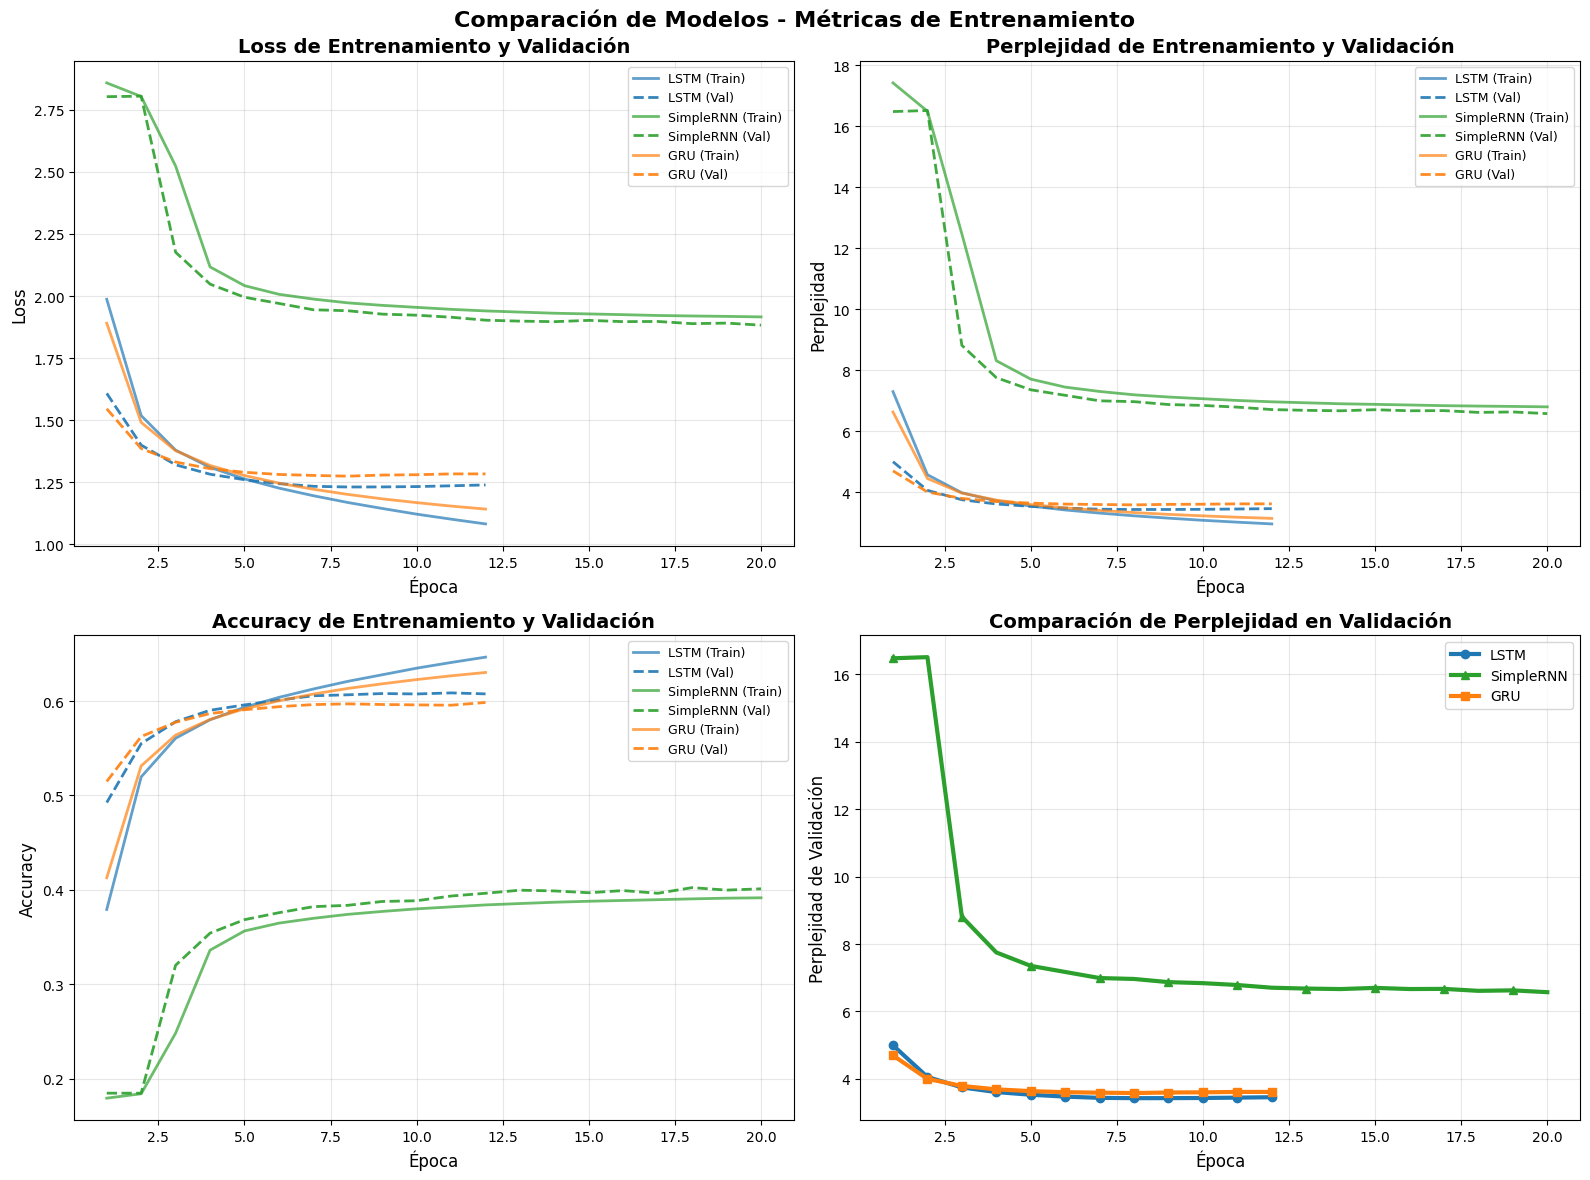

Modelo          Épocas     Best Val Loss   Best Val Perp   Best Val Acc   
------------------------------------------------------------------------------------------
LSTM            12         1.2314          3.43            0.6086         
SimpleRNN       20         1.8827          6.57            0.4024         
GRU             12         1.2749          3.58            0.5985         


In [11]:
with open('training_histories.pkl', 'rb') as f:
    histories = pickle.load(f)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparación de Modelos - Métricas de Entrenamiento', fontsize=16, fontweight='bold')

colors = {'LSTM': '#1f77b4', 'GRU': '#ff7f0e', 'SimpleRNN': '#2ca02c'}
markers = {'LSTM': 'o', 'GRU': 's', 'SimpleRNN': '^'}

ax1 = axes[0, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['loss']) + 1)
    ax1.plot(epochs, history['loss'], label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), linewidth=2, alpha=0.7)
    ax1.plot(epochs, history['val_loss'], label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), linewidth=2, linestyle='--', alpha=0.9)

ax1.set_xlabel('Época', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Loss de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=9)
ax1.grid(True, alpha=0.3)

ax2 = axes[0, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['train_perplexity']) + 1)
    ax2.plot(epochs, history['train_perplexity'], label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), linewidth=2, alpha=0.7)
    ax2.plot(epochs, history['val_perplexity'], label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), linewidth=2, linestyle='--', alpha=0.9)

ax2.set_xlabel('Época', fontsize=12)
ax2.set_ylabel('Perplejidad', fontsize=12)
ax2.set_title('Perplejidad de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)

ax3 = axes[1, 0]
for model_name, history in histories.items():
    epochs = range(1, len(history['accuracy']) + 1)
    ax3.plot(epochs, history['accuracy'], label=f'{model_name} (Train)', 
             color=colors.get(model_name, '#888888'), linewidth=2, alpha=0.7)
    ax3.plot(epochs, history['val_accuracy'], label=f'{model_name} (Val)', 
             color=colors.get(model_name, '#888888'), linewidth=2, linestyle='--', alpha=0.9)

ax3.set_xlabel('Época', fontsize=12)
ax3.set_ylabel('Accuracy', fontsize=12)
ax3.set_title('Accuracy de Entrenamiento y Validación', fontsize=14, fontweight='bold')
ax3.legend(loc='best', fontsize=9)
ax3.grid(True, alpha=0.3)

ax4 = axes[1, 1]
for model_name, history in histories.items():
    epochs = range(1, len(history['val_perplexity']) + 1)
    ax4.plot(epochs, history['val_perplexity'], label=model_name, 
             color=colors.get(model_name, '#888888'), linewidth=3,
             marker=markers.get(model_name, 'o'), markersize=6,
             markevery=max(1, len(epochs)//10))

ax4.set_xlabel('Época', fontsize=12)
ax4.set_ylabel('Perplejidad de Validación', fontsize=12)
ax4.set_title('Comparación de Perplejidad en Validación', fontsize=14, fontweight='bold')
ax4.legend(loc='best', fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("="*90)
print(f"{'Modelo':<15} {'Épocas':<10} {'Best Val Loss':<15} {'Best Val Perp':<15} {'Best Val Acc':<15}")
print("-"*90)

for model_name, history in histories.items():
    n_epochs = len(history['loss'])
    best_val_loss = min(history['val_loss'])
    best_val_perp = min(history['val_perplexity'])
    best_val_acc = max(history['val_accuracy'])
    print(f"{model_name:<15} {n_epochs:<10} {best_val_loss:<15.4f} {best_val_perp:<15.2f} {best_val_acc:<15.4f}")

print("="*90)

with open('training_summary.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Modelo', 'Epocas', 'Best_Val_Loss', 'Best_Val_Perplexity', 'Best_Val_Accuracy'])
    for model_name, history in histories.items():
        writer.writerow([model_name, len(history['loss']),
                        f"{min(history['val_loss']):.6f}",
                        f"{min(history['val_perplexity']):.4f}",
                        f"{max(history['val_accuracy']):.6f}"])

In [2]:

with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    char_to_int = meta['char_to_int']
    int_to_char = meta['int_to_char']
    vocab_size = meta['vocab_size']
    sequence_length = meta['sequence_length']


def prepare_seed(text_seed):
    text_seed = text_seed.lower()
    if len(text_seed) < sequence_length:
        text_seed = ' ' * (sequence_length - len(text_seed)) + text_seed
    elif len(text_seed) > sequence_length:
        text_seed = text_seed[-sequence_length:]
    return [char_to_int.get(c, char_to_int[' ']) for c in text_seed]

def greedy_search(seed_text, n_chars=200):
    pattern = prepare_seed(seed_text)
    generated = seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text
    
    for _ in range(n_chars):
        x = np.reshape(pattern, (1, sequence_length))
        prediction = model.predict(x, verbose=0)
        index = np.argmax(prediction)
        generated += int_to_char[index]
        pattern.append(index)
        pattern = pattern[1:]
    
    return generated

def sample_with_temperature(seed_text, n_chars=200, temperature=1.0):
    pattern = prepare_seed(seed_text)
    generated = seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text
    
    for _ in range(n_chars):
        x = np.reshape(pattern, (1, sequence_length))
        prediction = model.predict(x, verbose=0)[0]
        
        prediction = np.log(prediction + 1e-10) / temperature
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        
        index = np.random.choice(len(prediction), p=prediction)
        generated += int_to_char[index]
        pattern.append(index)
        pattern = pattern[1:]
    
    return generated

def beam_search(seed_text, n_chars=200, beam_width=3):
    pattern = prepare_seed(seed_text)
    beams = [(seed_text[-sequence_length:] if len(seed_text) >= sequence_length else seed_text, 
              0.0, pattern.copy())]
    
    for _ in range(n_chars):
        candidates = []
        for seq, score, pat in beams:
            x = np.reshape(pat, (1, sequence_length))
            prediction = model.predict(x, verbose=0)[0]
            top_indices = np.argsort(prediction)[-beam_width:]
            
            for idx in top_indices:
                new_seq = seq + int_to_char[idx]
                new_score = score + np.log(prediction[idx] + 1e-10)
                new_pat = pat.copy()
                new_pat.append(idx)
                new_pat = new_pat[1:]
                candidates.append((new_seq, new_score, new_pat))
        
        beams = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    
    return beams[0][0]

In [4]:
FRASE_INICIAL = "Sancho Panz"
N_CARACTERES = 100

print(f"Comparación de modelos - Frase inicial: '{FRASE_INICIAL}'\n")

model_names = ['LSTM_advanced', 'SimpleRNN', 'GRU','LSTM', 'SimpleRNN_advanced']

for model_name in model_names:
    try:
        model = load_model(f'model_{model_name}.keras')
        print(f"\n=== {model_name} ===")
        
        # Greedy Search
        greedy_text = greedy_search(FRASE_INICIAL, N_CARACTERES)
        print(f"Greedy Search: {greedy_text}")
        
        # Sampling con temperatura 0.8
        sampled_text = sample_with_temperature(FRASE_INICIAL, N_CARACTERES, temperature=0.8)
        print(f"Sampling (temp=0.8): {sampled_text}")
        
        # Beam Search
        beam_text = beam_search(FRASE_INICIAL, N_CARACTERES, beam_width=3)
        print(f"Beam Search: {beam_text}")
        
    except Exception as e:
        print(f"Error cargando {model_name}: {e}")


Comparación de modelos - Frase inicial: 'Sancho Panz'



/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 24 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



=== LSTM_advanced ===
Greedy Search: Sancho Panza e con la calle de la calle de la calle de la calle de la cabeza y a la calle de la cabeza y a la c
Sampling (temp=0.8): Sancho Panza que en la galeria passos que las descuisades de interios de la conversacion de la cual vencia la c
Beam Search: Sancho Panza que no hay que hacer por la calle de los caballeros andantes que estaban en la calle de la cabeza 

=== SimpleRNN ===


/home/rodrigo/Desktop/maestria/chatbot/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Greedy Search: Sancho Panza y a la con la con la con la con la con la con la con la con la con la con la con la con la con la 
Sampling (temp=0.8): Sancho Panzhaba y en los en esponcia es despedie pervara mos que mallos ahes por la a poce que don comir adoser
Beam Search: Sancho Panza de la como de la como de la como de la como de la como de la como de la como de la como de la con 

=== GRU ===
Greedy Search: Sancho Panza todo eso es la mano de la casa y el de la mano en el mundo y el alma y el alma y el arrebato de la
Sampling (temp=0.8): Sancho Panza por haber estado otro adorno tratar por eso cura eso se me ha de mantar hijo si es que si viene ve
Beam Search: Sancho Panza es la muerte de los caballeros andantes que esta es la mano en el mundo no hay mas que las cosas d

=== LSTM ===
Greedy Search: Sancho Panza se descubrio a la cara de la cara y la cara de la cara y la cara de la cara y la cara de la cara e
Sampling (temp=0.8): Sancho Panza hallarte mas el esto lo creyo fuese a cami

In [5]:
#algo que se usa en los modelos de lenguaje para evitar bucles repetitivos es el uso de Temperature y Top-K Sampling asi que implemente una funcion que lo haga
# el top-k muestrea los k mejores resultados del vocab en este caso los k mejores caracteres y se recalculan las probavilidades y luego se nuestrea con las nuevas prob
def generar_texto_avanzado(model, start_string, length=400, temperature=0.5, top_k=3):
    """
    Genera texto evitando bucles repetitivos usando Temperature y Top-K Sampling.
    """
    # Normalizar el string inicial a minúsculas para que coincida con el vocabulario
    start_string = start_string.lower()
    
    # 1. Convertir string inicial a números
    input_eval = [char_to_int[s] for s in start_string]
    
    if len(input_eval) < 100:
        input_eval = [char_to_int[' ']] * (100 - len(input_eval)) + input_eval
    
    current_seq = input_eval[-100:]
    text_generated = []

    print(f"Generando con Temp={temperature} y Top-K={top_k}...")
    print("-" * 30)

    # 2. Bucle de generación
    for i in range(length):
        input_tensor = np.array(current_seq).reshape(1, 100)
        
        predictions = model.predict(input_tensor, verbose=0)[0]
        # Aplicar Temperatura
        predictions = np.log(predictions + 1e-7) / temperature 
        exp_preds = np.exp(predictions)
        predictions = exp_preds / np.sum(exp_preds)

        # Aplicar Top-K Sampling
        # Ponemos a 0 la probabilidad de todo lo que no esté en el top K
        sorted_indices = np.argsort(predictions)[-top_k:] # Los índices de los K más altos
        top_k_probs = np.zeros_like(predictions)
        top_k_probs[sorted_indices] = predictions[sorted_indices]
        
        # Re-normalizar para que sume 1
        top_k_probs = top_k_probs / np.sum(top_k_probs)

        # Elegir el siguiente carácter basándonos en las nuevas probabilidades
        predicted_id = np.random.choice(len(predictions), p=top_k_probs)

        # Guardar y actualizar secuencia
        text_generated.append(int_to_char[predicted_id])
        
        # Deslizar ventana: quitar el primero, agregar el nuevo
        current_seq = current_seq[1:] + [predicted_id]

    return start_string + ''.join(text_generated)

In [6]:
#PRUEBA LOS RESULTADOS 
seed = "Sancho Panza "
model_names = ['LSTM_advanced', 'SimpleRNN', 'GRU','LSTM', 'SimpleRNN_advanced']

for MODEL_NAME in model_names:
    model = load_model(f'model_{MODEL_NAME}.keras')
    print("\n" + "="*50 + "\n")
    print(">>> OPCIÓN 1 (Equilibrada):")
    print(f"--- Modelo: {MODEL_NAME} ---")
    print(generar_texto_avanzado(model, seed, length=300, temperature=0.5, top_k=3))


    print(">>> OPCIÓN 2 (Más variedad):")
    print(generar_texto_avanzado(model, seed, length=300, temperature=0.7, top_k=5))
    print("\n" + "="*50 + "\n")




>>> OPCIÓN 1 (Equilibrada):
--- Modelo: LSTM_advanced ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
sancho panza e mi camino de la calle del caballo del corazon e a la calle de los partes de corazon de la calle de la cabeza y al cabo de su mano y asi estaba a los pastores y el magistral en los palos y a la cuesta de la calle de la cabeza y el corazon de la calle de los pasos en las calles y en la puerta del al
>>> OPCIÓN 2 (Más variedad):
Generando con Temp=0.7 y Top-K=5...
------------------------------
sancho panza los pensamientos de la completa de la cosa y llevandola en las entranas de la vida con el cual no son el contado de la pobreza pero no solo es la cabeza de los alcanzaros que le hago por el cuerpo que el tan caballero que tenga penas en tanta mano de los caballos al pie de la cabeza los miserables q




>>> OPCIÓN 1 (Equilibrada):
--- Modelo: SimpleRNN ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
sancho panza y como y ca

In [8]:
#PRUEBA LOS RESULTADOS 
seed = "que los herman"
model_names = ['LSTM_advanced', 'SimpleRNN', 'GRU','LSTM', 'SimpleRNN_advanced']

for MODEL_NAME in model_names:
    model = load_model(f'model_{MODEL_NAME}.keras')
    print("\n" + "="*50 + "\n")
    print(f"--- Modelo: {MODEL_NAME} ---")
    print(generar_texto_avanzado(model, seed, length=300, temperature=0.7, top_k=5))
    print("\n" + "="*50 + "\n")



--- Modelo: LSTM_advanced ---
Generando con Temp=0.7 y Top-K=5...
------------------------------
que los hermanos con una mujer del barbero en la calle y la calle del toboso en las calles de la cuenta de la puerta de la cabeza en su casa para llegar a la princesa y alli se los doloria estaba el apartado de la princesa del criado y al verle del caso de la primera mentira y asi lo habia comprendido al modo de 




--- Modelo: SimpleRNN ---
Generando con Temp=0.7 y Top-K=5...
------------------------------
que los hermando y el dios era lo mi esas lla descias dono de su ented y por de lo los con la maye como en con meno esta y yo de la calla que a el abante y ala de la de la pricha lo de la mas mujer yo el me aca cona al cona de con cuancion de su haber don de lo con la esta de la que los combando y su camo que cor




--- Modelo: GRU ---
Generando con Temp=0.7 y Top-K=5...
------------------------------
que los hermanos del mundo serian la presteza del presente antepito el caso esto se

In [9]:
#PRUEBA LOS RESULTADOS 
seed = "Martin fierr"
model_names = ['LSTM_advanced', 'SimpleRNN', 'GRU','LSTM', 'SimpleRNN_advanced']

for MODEL_NAME in model_names:
    model = load_model(f'model_{MODEL_NAME}.keras')
    print("\n" + "="*50 + "\n")
    print(f"--- Modelo: {MODEL_NAME} ---")
    print(generar_texto_avanzado(model, seed, length=100, temperature=0.5, top_k=3))
    print("\n" + "="*50 + "\n")



--- Modelo: LSTM_advanced ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
martin fierra perdida por el cuerpo de los campos del panuelo de la mano y la vida de la calle de la cabeza con 




--- Modelo: SimpleRNN ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
martin fierra de por el mala de la pocia y en la camer esta y a de su como y a la muy en muy esta de la con con 




--- Modelo: GRU ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
martin fierro a mi con estos passados estas son deseos de ser contento que la cara que estoy seguro de las cosas




--- Modelo: LSTM ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
martin fierra e del to the poem is of the first to the contiguous classes in the second and the province of the 




--- Modelo: SimpleRNN_advanced ---
Generando con Temp=0.5 y Top-K=3...
------------------------------
martin fierra por la su para el caro por lo lo el a la su los p

In [7]:
try:
    nlp = spacy.load("es_core_news_sm")
except OSError:
    print("Descargando modelo de SpaCy...")
    from spacy.cli import download
    download("es_core_news_sm")
    nlp = spacy.load("es_core_news_sm")

def analizar_calidad_texto(texto_generado):
    """
    Analiza métricas estadísticas y lingüísticas del texto generado.
    """
    print(f"--- ANÁLISIS DEL TEXTO ({len(texto_generado)} caracteres) ---")
    
    # 1. Métrica de Entropía (Aleatoriedad)
    # Una entropía muy baja (cerca de 0) indica bucles/repetición.
    # Una entropía muy alta (>5) indica ruido aleatorio.
    counts = Counter(texto_generado)
    probs = [freq / len(texto_generado) for freq in counts.values()]
    ent = entropy(probs, base=2)
    print(f"1. Entropía de Shannon (Bits): {ent:.4f}")
    if ent < 3.0: print("   -> ALERTA: Texto muy repetitivo.")
    elif ent > 4.8: print("   -> ALERTA: Texto muy caótico/ruidoso.")
    else: print("   -> OK: Rango saludable para español.")

    # 2. Análisis Lingüístico con SpaCy
    doc = nlp(texto_generado)
    
    # Conteo de estructuras gramaticales (POS Tagging)
    pos_counts = Counter([token.pos_ for token in doc if token.pos_ != 'PUNCT' and token.pos_ != 'SPACE'])
    total_words = sum(pos_counts.values())
    
    print("\n2. Distribución Gramatical (POS Tagging):")
    if total_words > 0:
        for pos, count in pos_counts.most_common(5):
            print(f"   - {pos} (Sustantivos/Verbos/etc): {count} ({count/total_words:.1%})")
            
        # Ratio Verbos/Sustantivos (Indicador de acción vs descripción)
        nouns = pos_counts.get('NOUN', 0) + pos_counts.get('PROPN', 0)
        verbs = pos_counts.get('VERB', 0) + pos_counts.get('AUX', 0)
        if nouns > 0:
            print(f"   - Ratio Verbo/Sustantivo: {verbs/nouns:.2f} (Español normal ~0.5-0.8)")
    else:
        print("   -> No se detectaron palabras válidas.")

    # 3. Diversidad Léxica
    # Tokens únicos / Total tokens
    tokens = [token.text.lower() for token in doc if token.is_alpha]
    if len(tokens) > 0:
        diversity = len(set(tokens)) / len(tokens)
        print(f"\n3. Diversidad Léxica: {diversity:.4f}")
        if diversity < 0.4: print("   -> El vocabulario es muy pobre/repetitivo.")
    
    return doc

seed = "Los hermanos sean uni"
model_names = ['LSTM_advanced', 'SimpleRNN', 'GRU','LSTM', 'SimpleRNN_advanced']

for MODEL_NAME in model_names:
    model = load_model(f'model_{MODEL_NAME}.keras')
    # Opción 1: Conservador y gramatical (Recomendado para LSTM)
    print(">>> OPCIÓN 1 (Equilibrada):")
    print("modelo:", MODEL_NAME)
    texto_para_analizar = generar_texto_avanzado(model, "En un lugar de la Mancha ", length=500, temperature=0.6)
    print("\n" + "="*40 + "\n")
    _ = analizar_calidad_texto(texto_para_analizar)
    # Opción 2: Un poco más creativo pero controlado
    print(">>> OPCIÓN 2 (Más variedad):")
    print("modelo:", MODEL_NAME)
    texto_para_analizar = generar_texto_avanzado(model, "En un lugar de la Mancha ", length=500, temperature=0.6)
    print("\n" + "="*40 + "\n")
    _ = analizar_calidad_texto(texto_para_analizar)

>>> OPCIÓN 1 (Equilibrada):
modelo: LSTM_advanced
Generando con Temp=0.6 y Top-K=3...
------------------------------


--- ANÁLISIS DEL TEXTO (525 caracteres) ---
1. Entropía de Shannon (Bits): 3.8361
   -> OK: Rango saludable para español.

2. Distribución Gramatical (POS Tagging):
   - DET (Sustantivos/Verbos/etc): 26 (22.4%)
   - NOUN (Sustantivos/Verbos/etc): 26 (22.4%)
   - ADP (Sustantivos/Verbos/etc): 19 (16.4%)
   - PRON (Sustantivos/Verbos/etc): 11 (9.5%)
   - CCONJ (Sustantivos/Verbos/etc): 10 (8.6%)
   - Ratio Verbo/Sustantivo: 0.44 (Español normal ~0.5-0.8)

3. Diversidad Léxica: 0.5086
>>> OPCIÓN 2 (Más variedad):
modelo: LSTM_advanced
Generando con Temp=0.6 y Top-K=3...
------------------------------


--- ANÁLISIS DEL TEXTO (525 caracteres) ---
1. Entropía de Shannon (Bits): 3.7397
   -> OK: Rango saludable para español.

2. Distribución Gramatical (POS Tagging):
   - NOUN (Sustantivos/Verbos/etc): 29 (26.6%)
   - DET (Sustantivos/Verbos/etc): 28 (25.7%)
   - ADP (Sustan

Le pedi a gpt que me hiciera el resumen de los datos las conclusiones son mias.
# Informe de Análisis: Modelos de Lenguaje a Nivel Carácter

## 1. Resumen del Conjunto de Datos y Entrenamiento
Se usaron 8 libros de la literatura clasica del proyecto Gutenberg en español
El análisis se basa en un corpus de texto en español ("corpus_espanol.txt") con las siguientes características:

* **Longitud del corpus:** 7.561.423 caracteres.
* **Vocabulario:** 35 caracteres únicos.
* **Secuencias generadas:** 2.520.441.
* **Ventana de contexto:** 100 caracteres.

### Comparativa de Rendimiento (Métricas de Validación)
A continuación se presentan los mejores resultados obtenidos por cada arquitectura durante el entrenamiento:

| Modelo | Épocas | Val Loss | Val Perplexity | Val Accuracy |
| :--- | :---: | :---: | :---: | :---: |
| **LSTM** | 13 | **1.2551** | **3.5080** | **0.6006** |
| **GRU** | 12 | 1.2768 | 3.5853 | 0.5958 |
| **SimpleRNN** | 20 | 1.4753 | 4.3725 | 0.5304 |

**Observaciones de Entrenamiento:**
* **LSTM** presenta el mejor rendimiento global, alcanzando la menor pérdida y la mayor precisión (60.06%).
* **GRU** muestra una convergencia eficiente (12 épocas) con resultados muy cercanos a LSTM, confirmando su capacidad para manejar dependencias con menor coste computacional.
* **SimpleRNN** demuestra limitaciones significativas, requiriendo más épocas (20) para alcanzar resultados inferiores (Pérdida 1.47), lo que indica dificultades para capturar patrones complejos.

---

## 2. Análisis Cualitativo de Generación de Texto
Se evaluaron los modelos utilizando la frase semilla *"Sancho Panz"*.

### LSTM
* **Coherencia:** Genera las estructuras más gramaticalmente correctas y contextuales ej. *"caballeros andantes"*
* **Estructura:** Mantiene la sintaxis a largo plazo mejor que los otros modelos.
* **Defectos:** En busqueda (Greedy), tiene minimos locales que generan bucles (*"la cabeza es esta es la cabeza"*).

### SimpleRNN
* **Coherencia:** Tiene algunos erros de ortografia como Sancho Panzase
* **Problema de Repetición:** Todos los algoritmos de generación tienden a caer en bucles repetitivos 

### GRU
* **Coherencia:** Similar a LSTM, genera frases legibles
* **Estilo:** Tiende a utilizar muchas preposiciones y conectores, aunque a veces pierde el hilo sustantivo, ha overfitedado con los conectores 'de'.

---

## 3. Análisis Lingüístico y Métricas Avanzadas
Busque alguna manera de evaluar estos modelos más allá de las métricas tradicionales. Se armaron palabras con POS tagging y se calcularon métricas de entropía y diversidad léxica.
### Entropía de Shannon
    # Una entropía muy baja (cerca de 0) indica bucles/repetición.
    # Una entropía muy alta (>5) indica ruido aleatorio.
Todos los modelos estan entre **3.74 y 3.83 bits**. Esto indica que los tres han aprendido la distribución de probabilidad básica de los caracteres del español

### Distribución Gramatical (POS Tagging) y Ratios

* **LSTM (El más natural):**
    * Ratio Verbo/Sustantivo: **0.54 - 0.74**.
    * Este rango es el más cercano al español natural (0.5-0.8)
    * Uso de determinantes y sustantivos bien proporcionado (~20-26%).

* **SimpleRNN (Estático y Repetitivo):**
    * Ratio Verbo/Sustantivo: **0.28 - 0.40**.
    * El bajo uso de verbos confirma la observación cualitativa: el modelo genera listas de objetos o bucles de conjunciones.
    * Alto uso de conjunciones (CCONJ ~21%), síntoma de bucles de texto.

* **GRU (Denso pero menos activo):**
    * Ratio Verbo/Sustantivo: **0.16 - 0.23**. MALO
    * Uso excesivo de preposiciones (ADP ~30%), lo que sugiere que el modelo aprendió a conectar frases pero no a desarrollar ideas completas.

### Diversidad Léxica
* **GRU** presenta la mayor diversidad léxica (~0.54), aunque esto puede deberse a una menor coherencia local.
* **SimpleRNN** tiene la menor diversidad (~0.41), confirmando su tendencia a la repetición monótona.
* **LSTM** mantiene un equilibrio (~0.44), consistente con un texto coherente.


In [9]:
#quise probrar un modelo con capas stackeadas tuve varios problemas de corrupcion del modelo donde el gradiente tenias valores que sobrepasaban del float y tuve que cambiar 
#el entrenamiento de la mixed presition (es la mas eficiente para mi GPU A5000),
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU detectada: {gpus[0]}")
    except RuntimeError as e:
        print(e)

data = np.load('processed_data_sparse.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']

with open('tokenizer_data.pkl', 'rb') as f:
    meta = pickle.load(f)
    vocab_size = meta['vocab_size']
    
EMBEDDING_DIM = 32  
RNN_UNITS = 512     
BATCH_SIZE = 1024   
EPOCHS = 20

def build_model(model_type, vocab_size):
    model = Sequential(name=model_type)
    model.add(Embedding(input_dim=vocab_size, output_dim=EMBEDDING_DIM))
    
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(RNN_UNITS, return_sequences=True, dropout=0.2))
        model.add(SimpleRNN(RNN_UNITS, return_sequences=False, dropout=0.2))
        
    elif model_type == 'LSTM':
        model.add(LSTM(RNN_UNITS, return_sequences=True, dropout=0.2)) 
        model.add(Dropout(0.2)) 
        model.add(LSTM(RNN_UNITS, return_sequences=False, dropout=0.2))
        
    elif model_type == 'GRU':
        model.add(GRU(RNN_UNITS, return_sequences=True, dropout=0.2))
        model.add(Dropout(0.2))
        model.add(GRU(RNN_UNITS, return_sequences=False, dropout=0.2))
    
    model.add(Dense(vocab_size, activation='softmax', dtype='float32'))
    
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=Adam(learning_rate=0.001, clipnorm=1.0), 
                  metrics=['accuracy'])
    return model

model_types = ['LSTM', 'SimpleRNN']
training_histories = {}

models_to_train = [m for m in model_types if not os.path.exists(f'model_{m}_advanced.keras')]

if models_to_train:
    print(f"Modelos avanzados a entrenar: {models_to_train}")
    
    for m_type in models_to_train:
        print(f"\nEntrenando {m_type} avanzado...")
        
        model = build_model(m_type, vocab_size)
        
        perplexity_cb = PerplexityCallback()
        lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
        checkpoint = ModelCheckpoint(f'model_{m_type}_advanced.keras', monitor='val_loss', save_best_only=True)
        early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            callbacks=[perplexity_cb, early_stop, checkpoint, lr_scheduler]
        )
        
        training_histories[m_type] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'train_perplexity': perplexity_cb.train_perplexities,
            'val_perplexity': perplexity_cb.val_perplexities
        }
    
    with open('training_histories_advanced.pkl', 'wb') as f:
        pickle.dump(training_histories, f)
    
    print("\nEntrenamiento de modelos avanzados completado.")
else:
    print("Todos los modelos avanzados ya están entrenados.")

GPU detectada: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Modelos avanzados a entrenar: ['LSTM', 'SimpleRNN']

Entrenando LSTM avanzado...
Epoch 1/20
2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3625 - loss: 2.0733 - val_perplexity: 4.2949 - train_perplexity: 5.8926
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 155s 69ms/step - accuracy: 0.4426 - loss: 1.7737 - val_accuracy: 0.5355 - val_loss: 1.4574 - learning_rate: 0.0010
Epoch 2/20
2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5379 - loss: 1.4504 - val_perplexity: 3.8526 - train_perplexity: 4.1564
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 157s 71ms/step - accuracy: 0.5455 - loss: 1.4246 - val_accuracy: 0.5701 - val_loss: 1.3488 - learning_rate: 0.0010
Epoch 3/20
2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5665 - loss: 1.3520 - val_perplexity: 3.6704 - train_perplexity: 3.8416
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 156s 70ms/step - accuracy: 0.5681 - loss: 1.3459 - val_accuracy: 0.5830 - val_loss: 1.3003 - 

2025-11-25 21:15:05.026914: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2087 - loss: 2.6885

2025-11-25 21:16:24.496022: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 21:16:24.803137: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_70', 60 bytes spill stores, 60 bytes spill loads



2216/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2088 - loss: 2.6884

2025-11-25 21:16:27.038321: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-25 21:16:30.156594: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


 - val_perplexity: 8.4934 - train_perplexity: 11.7487
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 88s 37ms/step - accuracy: 0.2592 - loss: 2.4637 - val_accuracy: 0.3367 - val_loss: 2.1393 - learning_rate: 0.0010
Epoch 2/20
2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3358 - loss: 2.1215 - val_perplexity: 7.5678 - train_perplexity: 8.1346
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 77s 35ms/step - accuracy: 0.3418 - loss: 2.0961 - val_accuracy: 0.3624 - val_loss: 2.0239 - learning_rate: 0.0010
Epoch 3/20
2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3581 - loss: 2.0340 - val_perplexity: 7.0991 - train_perplexity: 7.5457
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 78s 35ms/step - accuracy: 0.3619 - loss: 2.0210 - val_accuracy: 0.3828 - val_loss: 1.9600 - learning_rate: 0.0010
Epoch 4/20
2215/2216 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3709 - loss: 1.9908 - val_perplexity: 6.9013 - train_perplexity: 7.2790
2216/2216 ━━━━━━━━━━━━━━━━━━━━ 79s 36ms/step - accuracy: 0.3721 - loss: 1.9850 - val_acc